<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/Media_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#10조. 네이버 댓글 분석을 통한 상위, 하위 클립 예측

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls ../gdrive/My\ Drive/output

file_ep10.csv	 file_ep16.csv	file_ep22.csv  file_ep4.csv
file_ep11.csv	 file_ep17.csv	file_ep23.csv  file_ep5.csv
file_ep12.csv	 file_ep18.csv	file_ep24.csv  file_ep6.csv
file_ep13.csv	 file_ep19.csv	file_ep25.csv  file_ep7.csv
file_ep14_1.csv  file_ep1.csv	file_ep26.csv  file_ep8.csv
file_ep14.csv	 file_ep20.csv	file_ep2.csv   file_ep9.csv
file_ep15.csv	 file_ep21.csv	file_ep3.csv   TheLastEmpress.csv


In [3]:
!pip install regex

     |████████████████████████████████| 645kB 4.9MB/s 


In [4]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys
import regex as re
import random

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#데이터 분리를 위한 라이브러리 로드
from sklearn.model_selection import train_test_split

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


In [5]:
filelist = os.listdir('../gdrive/My Drive/output')
filelist

['file_ep1.csv',
 'file_ep16.csv',
 'file_ep17.csv',
 'file_ep10.csv',
 'file_ep14.csv',
 'file_ep12.csv',
 'file_ep11.csv',
 'file_ep14_1.csv',
 'file_ep15.csv',
 'file_ep13.csv',
 'file_ep18.csv',
 'file_ep19.csv',
 'file_ep21.csv',
 'file_ep20.csv',
 'file_ep2.csv',
 'file_ep22.csv',
 'file_ep23.csv',
 'file_ep25.csv',
 'file_ep24.csv',
 'file_ep26.csv',
 'file_ep3.csv',
 'file_ep4.csv',
 'file_ep5.csv',
 'file_ep6.csv',
 'file_ep9.csv',
 'file_ep7.csv',
 'TheLastEmpress.csv',
 'file_ep8.csv']

In [6]:
# 총 26회차 491개 하이라이트 클립 존재 (전체 재생수 = 107,221,654 / 클립 당 평균 재생수 = 218,374), 
# 이 중에서 예고편, 미공개, 인터뷰 등 클립 제외하고 총 422회 클립 대상
df_title = pd.read_csv('../gdrive/My Drive/output/TheLastEmpress.csv', encoding = 'euc-kr')
df_title.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 조회수 분포를 고려하여 각 회차별로 조회수 상위 4개, 하위 4개 클립을 샘플링 - 총 208개 클립
# 좋아요수, 댓글 수, 댓글 내용, 댓글 작성자 정보 (웹크롤링 통한 추출)

df_ep_tot = pd.DataFrame()
for i in tqdm_notebook(filelist):
  if (i[:4] == 'file'):
    df_ep_temp = pd.read_csv('../gdrive/My Drive/output/'+i)
    df_ep_temp['play'] = df_ep_temp['play'].apply(lambda x: int(re.sub(',','', x[4:])))
    df_ep_temp['rank'] = df_ep_temp['play'].rank(method='dense', ascending=False)
    df_ep_tot = df_ep_tot.append(df_ep_temp)

df_ep_tot.drop(columns='Unnamed: 0', inplace=True)
df_ep_tot['target'] = np.where(df_ep_tot['rank']<=4,1,0)
df_ep_tot

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1841,Major,와 ㅅㅂ...피지컬봐....,550,1,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1842,스폰지밥,"이쁘십니다 할때 나만설렜냐,,,,,,,",691,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1843,박한별,반했네,372,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0
1844,김민정,죄송하지만 이 분 이용합시다 ! 어쨌든 좋은게 좋은거죠 ..,593,4,"이희진, 근육남 최진혁에 공주표 애교 “마이 아포”",155236,645,173,8,8.0,0


In [7]:
display(df_title.head())
display(df_title.info())

,episode,title,play
0,14,"[숨멎 엔딩] 신성록, 설렘 폭발하는 반전 섹시미!",892539
1,8,"장나라, 악녀 이엘리야 때려잡는 카리스마 “얻다대고 반말”",852569
2,19,신은경 완벽 빙의한 ‘오아린 더빙 연기’,811897
3,10,"“사랑해요 폐하” 장나라, 신성록 계획 박살 내며 ‘흑화 스위치 ON’",757992
4,10,"뛰는 이엘리야 위 나는 오아린, 혼신의 눈물 연기(Feat. 윤소이 불꽃 따귀)",725808


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 3 columns):
episode    422 non-null int64
title      422 non-null object
play       422 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.0+ KB


None

In [8]:
display(df_ep_tot.head())
display(df_ep_tot.info())
# df_ep_tot[df_ep_tot['episode'] == 1].sample(10).sort_values(by='play', ascending = False)

,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐? 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40935 entries, 0 to 1845
Data columns (total 11 columns):
nick           40935 non-null object
contents       40801 non-null object
recomm         40935 non-null int64
unrecomm       40935 non-null int64
title          40935 non-null object
play           40935 non-null int64
like           40935 non-null object
reple_count    40935 non-null object
episode        40935 non-null int64
rank           40935 non-null float64
target         40935 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


None

### 1화 댓글 대상 sample set test

In [9]:
# df_ep_sample = df_ep_tot[df_ep_tot['episode'] == 1].copy()
df_ep_sample = df_ep_tot.copy()
df_ep_sample.dropna(how='any', inplace=True)
df_ep_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40801 entries, 0 to 1845
Data columns (total 11 columns):
nick           40801 non-null object
contents       40801 non-null object
recomm         40801 non-null int64
unrecomm       40801 non-null int64
title          40801 non-null object
play           40801 non-null int64
like           40801 non-null object
reple_count    40801 non-null object
episode        40801 non-null int64
rank           40801 non-null float64
target         40801 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


In [10]:
!pip3 install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 
     |████████████████████████████████| 2.7MB 43.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [0]:
import konlpy
from konlpy.tag import Kkma, Okt
from konlpy.utils import pprint

okt =Okt()
kkma = Kkma()
# mecab = Mecab()
# pprint(kkma.sentences(u'네, 안녕하세요. 반갑습니다.'))

# sentence = u'만 6세 이하의 초등학교 취학 전 자녀를 양육하기 위해서는'
# words = konlpy.tag.Twitter().pos(sentence)
# print(words)

In [0]:
def morphs_okt(x):
  res = okt.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = '' if not res else res
  return res

def morphs_kkma(x):
  res = kkma.morphs(x)
  if len(res) >= 1:
    res = [re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) for i in range(len(res)) if re.sub('[ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣ ]', '', res[i]) != '' and len(res[i]) >= 1]
  else:
    res = ''
  res = '' if not res else res
  return res

# def morphs_mecab(x):
#   res = kkma.morphs(x)
#   if len(res) > 1:
#     res = [re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》ㅋㅡ ]', '', res[i]) for i in range(len(res)) if len(res[i]) > 1]
#   else:
#     res = ''
#   return res

In [0]:
df_ep_sample['contents'] = df_ep_sample['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# df_ep_sample['okt_token'] = df_ep_sample['contents'].apply(lambda x: morphs_okt(x))
# df_ep_sample['kkma_token'] = df_ep_sample['contents'].apply(lambda x: morphs_kkma(x))
# df_ep_sample['kkma_token_str'] = df_ep_sample['kkma_token'].apply(lambda x: ' '.join(x))
# df_ep_sample

In [0]:
df_ep_sample.dropna(how='any',inplace=True)
# df_ep_sample['okt_token_str'] = df_ep_sample['okt_token'].apply(lambda x: ' '.join(x))

In [15]:
# df_ep_sample = df_ep_sample[df_ep_sample['okt_token'].str.len()>0]
df_ep_sample.info()
df_ep_sample.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40801 entries, 0 to 1845
Data columns (total 11 columns):
nick           40801 non-null object
contents       40801 non-null object
recomm         40801 non-null int64
unrecomm       40801 non-null int64
title          40801 non-null object
play           40801 non-null int64
like           40801 non-null object
reple_count    40801 non-null object
episode        40801 non-null int64
rank           40801 non-null float64
target         40801 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


,nick,contents,recomm,unrecomm,title,play,like,reple_count,episode,rank,target
0,rosi****,ㅅㅂ옷입고 목욕탕 들어가는거 ㅈㄴ웃기넼ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ저거 명품일 텐데ㅋㅋㅋㅋ...,5,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
1,핑크에메랄드,왠지 선황제가 바람은 못폈을거 같다는 생각이 든다 태후가 황후로 있는한 감히 생각도...,2,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
2,서지안,ㅋㅋㅋㅋㅋㅋㅋㅋ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
3,경,ㅏ,0,0,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1
4,홍홍,이게 나라냐 방송에서 이딴수위가 나오고 지랄이야 진짜 개좃헬조선 시발,3,5,"신은경, 핸드폰 너머 이엘리야의 의도적 신음에 ‘분노 폭발’",474498,842,185,1,1.0,1


## 공통 영역: Word Embedding을 위한 Hyper parameter Tuning

In [16]:
# Hyper Param setting

# token의 Histogram 분포를 바탕으로 대부분의 단어 길이 cover 가능한 단어 개수 찾기
# # 신경망 학습을 위한 input 벡터 길이로 사용 - 적정 길이는 tokenizng 이후 분포를 보고 결정(코드 하단)
# totalLenSent = [len(x) for x in df_ep_sample['okt_token']] # 각 document의 단어 길이를 check
# plt.hist(totalLenSent,bins = np.arange(0,max(totalLenSent),max(totalLenSent)/20))

# print(np.percentile(totalLenSent, 95)) # 95%를 커버하는 수치는 41

# MAX_LEN = int(np.percentile(totalLenSent, 95)) but bert는 128 embedding 사용
MAX_LEN = 128
print(MAX_LEN)

# pre-trained Embedding을 몇 개 사용할 지 결정
NUM_MODELS = 1

# # input data 원문에서 보존할 최대 단어 개수 
# # 전체 데이터셋에서 나타나는 unique 한 단어 수(넉넉하게 백단위 올림하여 setting)
# from itertools import chain

# sum_lists = list(chain.from_iterable(df_ep_sample['okt_token']))
# totalCntWords = int(math.ceil(len(set(sum_lists))/100)*100)

MAX_FEATURES = 37000
# MAX_FEATURES = totalCntWords
# print(len(set(sum_lists)), MAX_FEATURES)

128


## Bert

In [17]:
!pip install sacremoses sentencepiece 

     |████████████████████████████████| 860kB 5.1MB/s 
     |████████████████████████████████| 1.0MB 56.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=08bdc43b1390b9756395449fe1dcdac27a726f0a0cf7bebb3b6e4a87ac904741
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [18]:
# !ls ../gdrive/My\ Drive/data/transformers
!ls ../gdrive/My\ Drive/data/bert/bert-base-multilingual-cased

bert-base-multilingual-cased-vocab.txt	bert_config.json  pytorch_model.bin


### Pytorch 환경 내에서 BERT를 사용하기 위한 BERT 관련 Library Load

In [0]:
PATH_PRETRAINED = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased"
PATH_VOCAB = "../gdrive/My Drive/data/bert/bert-base-multilingual-cased"
PATH_BERT = "../gdrive/My Drive/data/bert"
sys.path.append(PATH_PRETRAINED)
sys.path.append(PATH_BERT)

import sacremoses
import sentencepiece

import pickle
import shutil
from joblib import Parallel, delayed

import torch
import torch.nn as nn # for neural net
import torch.utils.data
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from IPython.core.interactiveshell import InteractiveShell # jupyter에서 마지막 값만 출력하는게 아니라 모든 출력값을 매번 연속적으로 출력
InteractiveShell.ast_node_interactivity = "all" # all, last, last_expr, none (기본값은 'last_expr')

# from transformers import convert_tf_checkpoint_to_pytorch
from transformers import convert_bert_original_tf_checkpoint_to_pytorch

# from transformers import BertTokenizer, BertForSequenceClassification, BertAdam
from transformers import BertTokenizer, AdamW, BertModel, BertPreTrainedModel, BertConfig
from transformers.optimization import get_linear_schedule_with_warmup

from transformers import BertConfig # This is the Bert configuration file

### BERT 사용 관련 Hyperparameter Setting

In [20]:
seed = 42
MAX_SEQ_LEN = MAX_LEN # token분포 바탕으로 128 선정 (대부분의 단어 길이 cover)

NUM_LABELS = len(df_ep_sample['target'].unique()) #2 If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy)
training_epochs = 4
lr = 2e-5
warmup = 0.05
batch_size = 32

bert_model_config = PATH_PRETRAINED+'/bert_config.json'

bert_model = 'bert-base-multilingual-cased'
do_lower_case = 'uncased' in bert_model
device = torch.device('cuda') # GPU 사용 setting

output_model_file = 'bert_pytorch.bin'
output_optimizer_file = 'bert_pytorch_optimizer.bin'
# output_amp_file = 'bert_pytorch_amp.bin'

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
# class BertForSequenceClassification(BertPreTrainedModel):
#     r"""
#         **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
#             Labels for computing the sequence classification/regression loss.
#             Indices should be in ``[0, ..., config.num_labels - 1]``.
#             If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
#             If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).
#     Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
#         **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
#             Classification (or regression if config.num_labels==1) loss.
#         **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
#             Classification (or regression if config.num_labels==1) scores (before SoftMax).
#         **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
#             list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
#             of shape ``(batch_size, sequence_length, hidden_size)``:
#             Hidden-states of the model at the output of each layer plus the initial embedding outputs.
#         **attentions**: (`optional`, returned when ``config.output_attentions=True``)
#             list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
#             Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
#     Examples::
#         tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#         model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
#         input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
#         labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
#         outputs = model(input_ids, labels=labels)
#         loss, logits = outputs[:2]
#     """
#     def __init__(self, config):
#         super(BertForSequenceClassification, self).__init__(config)
#         self.num_labels = config.num_labels

#         self.bert = BertModel(config)
#         self.dropout = nn.Dropout(config.hidden_dropout_prob)
#         self.classifier = nn.Linear(config.hidden_size, self.config.num_labels-1)
#         self.init_weights()

#     def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
#                 position_ids=None, head_mask=None, inputs_embeds=None, labels=None):

#         outputs = self.bert(input_ids,
#                             attention_mask=attention_mask,
#                             token_type_ids=token_type_ids,
#                             position_ids=position_ids,
#                             head_mask=head_mask,
#                             inputs_embeds=inputs_embeds)

#         pooled_output = outputs[1]

#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)

#         return logits

In [0]:
class BertForSequenceClassification(BertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).
    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
    Examples::
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]
    """
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):

        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [0]:
# Converting the lines to BERT format # do token-convert-to-ids
# Thanks to https://www.kaggle.com/httpwwwfszyc/bert-in-keras-taming
def convert_bert_token(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_tokens = []
    longer = 0
    for text in tqdm_notebook(example):
        # print("text :", text)
        tokens_a = tokenizer.tokenize(text)
        # print("tokens_a : ", tokens_a)
        if len(tokens_a)>max_seq_length:  #token의 길이가 max_seq_length보다 길면 max_seq_length 뒤로는 잘라내고, longer 변수를 1증가 시킴
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        # token의 앞 뒤에 [CLS]와 [SEP]을 추가 시키고 남는자리는 zero padding
        # print("max_seq_length: ", max_seq_length, "len(tokens_a): ", len(tokens_a), "max_seq_length - len(tokens_a) : ", max_seq_length - len(tokens_a))

        # """ Converts a token (str/unicode) in an id using the vocab. """
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+ [0] * int(max_seq_length - len(tokens_a)) # token을 vocab을 이용하여 id로 convert
        all_tokens.append(one_token) # all_tokens에 추가
    # print(longer)
    return np.array(all_tokens)

def create_attention_masks(sequence):
# Create attention masks
  attention_masks = []

  # Create a mask of 1s for each token followed by 0s for padding
  for seq in sequence:
    # print("seq is ", seq)
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  # print(attention_masks)
  return attention_masks

In [24]:
!ls ../gdrive/My\ Drive/data/bert/bert-base-multilingual-cased/

bert-base-multilingual-cased-vocab.txt	bert_config.json  pytorch_model.bin


In [25]:
# OKT로 Tokenize 한 데이터를 string으로 붙인 뒤 이를 다시 bert 형태로 tokenizing

%%time

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=do_lower_case)
# tokens_a :  ['[UNK]', '목', '##욕', '##탕', '들어', '##가는', '##거', '[UNK]', '명', '##품', '##일', '[UNK]']
# tokens_a :  ['[UNK]', '선', '##황', '##제가', '바', '##람', '##은', '[UNK]', '같다', '##는', '생', '##각', '##이', '든', '##다', '태', '##후', '##가', '황', '##후', '##로', '있는', '##한', '감', '##히', '생', '##각', '##도', '못', '##했', '##을', '##듯']
# tokens_a :  ['[UNK]']

# tokenizer = BertTokenizer.from_pretrained(PATH_VOCAB+'/bert-base-multilingual-cased-vocab.txt', do_lower_case=do_lower_case)
# tokens_a :  ['옷', '입', '##고', '목', '##욕', '##탕', '들어', '##가는', '##거', '웃', '##기', '[UNK]', '저', '거', '명', '##품', '일', '텐', '##데']
# tokens_a :  ['[UNK]', '선', '황', '##제', '가', '바', '##람', '은', '못', '[UNK]', '같다', '##는', '생', '##각', '이', '든', '##다', '태', '##후', '가', '황', '##후', '로', '있는', '##한', '감', '##히', '생', '##각', '도', '못', '했', '##을', '##듯']

# train_df의 "comment_text"에서 na를 "DUMMY_VALUE"로 채우고, 최대 MAX_SEQUENCE_LENGTH 만큼 잘라냄
# sequences = convert_bert_token(df_ep_sample["okt_token_str"].fillna("DUMMY_VALUE"),MAX_SEQ_LEN, tokenizer)
sequences = convert_bert_token(df_ep_sample["contents"].fillna("DUMMY_VALUE"),MAX_SEQ_LEN, tokenizer)
attention_masks = np.asarray(create_attention_masks(sequences))


INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache or force_download set to True, downloading to /tmp/tmpvc2uud56
100%|██████████| 995526/995526 [00:00<00:00, 2625253.18B/s]
INFO:transformers.file_utils:copying /tmp/tmpvc2uud56 to cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:transformers.file_utils:removing temp file /tmp/tmpvc2uud56
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadb


CPU times: user 11.9 s, sys: 175 ms, total: 12 s
Wall time: 13 s


In [0]:
# BertTokenization 한 Embedding + Target 변수 (Series를 numpy로 변환하면 (x,) 형태의 출력이기 때문에 열 추가를 위해 reshape 해줌)
# all_lines = np.hstack((sequences, df_ep_sample['target'].to_numpy().reshape(-1,1)))
# all_lines.shape

X = sequences
Y = df_ep_sample['target'].to_numpy()
# Y = df_ep_sample['target'].to_numpy().reshape(-1,1)

# Train & Test Set 분리
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.15, random_state=seed)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=seed)

In [27]:
# Dataset을 상속한 TensorDataset은 train data x와 레이블 y를 묶어놓은 컨테이너로 tensor만 전달 가능함
# X는 torch.long 형태의 텐서로, y는 torch.float 타입의 텐서로 입력하여 pytorch에서 연산할 수 있는 기본 구조로 변경하여 train_dataset으로 할당
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x,dtype=torch.long), torch.tensor(train_y,dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x,dtype=torch.long), torch.tensor(test_y,dtype=torch.long))
# train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_x), torch.tensor(train_y))
# test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_x), torch.tensor(test_y))

print(train_x.shape)
print(train_y.shape)

(29478, 128)
(29478,)


In [28]:
train_dataset.tensors[1].shape
train_dataset.tensors[1].unsqueeze(1).shape

torch.Size([29478])

torch.Size([29478, 1])

In [0]:
# m = nn.Sigmoid()
# input = torch.randn(2)
# print(input, input.shape)
# output = m(input)
# print(output, output.shape)

In [0]:
train_losses = []

# Train 함수
def bert_train_net(net, train_loader, optimizer, device="cuda"):
  tq = tqdm_notebook(range(training_epochs))

  for epoch in tq:
    tr_loss = 0.
    nb_tr_examples, nb_tr_steps = 0,0

    # 신경망을 훈련 모드로 설정
    net.train()
    tk0 = tqdm_notebook(enumerate(train_loader),total=len(train_loader),leave=False)
    
    # iteration 1회에 train_loader의 batch_size (여기서는 64)만큼씩 읽어와 한꺼번에 batch처리 batch_size * i (여기서는 i = ) 가 전체 train data set의 크기가 될때까지 loop
    for i,(x, y) in tk0:
      x=x.to(device) # len(x)는 batch_size
      y=y.to(device)

      # y_pred = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=None)  # forward
      # loss = F.binary_cross_entropy_with_logits(y_pred.view_as(y),y)
      # loss = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=y) 
      # print(loss)
      optimizer.zero_grad() # step과 zero_grad는 쌍을 이루는 것이라고 생각하면 됨 # optimizer의 gradient를 0으로 초기화
      loss, logit = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=y)  # forward

      train_losses.append(loss.item())

      # print("loss ... ", loss, type(loss))
      loss.backward() # backpropagation
      optimizer.step() # update gradients

      # update tracking variables
      tr_loss += loss.item()
      nb_tr_examples += x.size(0)
      nb_tr_steps += 1
      # running_loss += loss.item() # loss calculate

      train_losses.append(tr_loss/nb_tr_steps))

    print("epoch: {}/{} | train_loss: {:.4f} ".format(epoch, training_epochs, tr_loss/nb_tr_steps))
    # train_losses.append(running_loss/len(train_loader))
    # torch.save(model.state_dict(), output_model_file)

In [31]:
# BertForSequenceClassification is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. 
# As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

bert_config = BertConfig.from_json_file(bert_model_config)
bert_config.num_labels = NUM_LABELS

# load pre-trained BERT model's weight in ../
model = BertForSequenceClassification.from_pretrained(PATH_PRETRAINED, config=bert_config)

param_optimizer = list(model.named_parameters())

# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

### In Transformers, optimizer and schedules are splitted and instantiated like this:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

INFO:transformers.modeling_utils:loading weights file ../gdrive/My Drive/data/bert/bert-base-multilingual-cased/pytorch_model.bin
INFO:transformers.modeling_utils:Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
INFO:transformers.modeling_utils:Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']


In [32]:
model.to(device) # GPU 연산을 위해 cuda로 전송

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
bert_train_net(model, train_loader, optimizer, device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

epoch: 0/4 | train_loss: 0.5435 


epoch: 1/4 | train_loss: 0.5016 


epoch: 2/4 | train_loss: 0.4564 


epoch: 3/4 | train_loss: 0.3991 



<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Training loss')

Text(0.5, 0, 'Batch')

Text(0, 0.5, 'Loss')

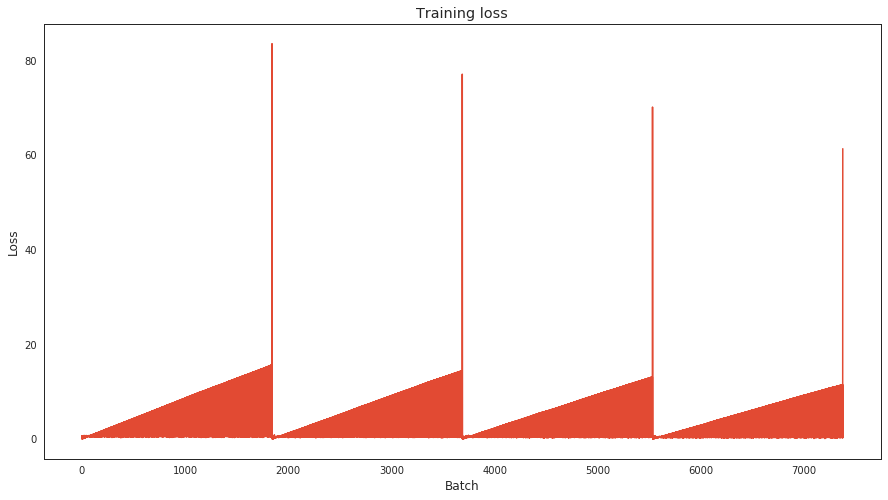

In [33]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(y_preds, real_ys):
    print(type(y_preds))
    pred_flat = np.argmax(y_preds, axis=1).flatten()
    labels_flat = real_ys.flatten()
    print("pred_flat : ", pred_flat)
    print("labels_flat :", labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# 평가 헬퍼 함수
def bert_eval_net(net, data_loader, device="cuda"):
  # Dropout 및 BatchNorm 무효화
  net.eval()

  eval_acc = 0
  nb_eval_examples, nb_eval_steps = 0,0

  for x, y in data_loader:
    x=x.to(device)
    y=y.to(device)
    with torch.no_grad():
      y_preds = net(x, token_type_ids=None, attention_mask=(x>0).to(device), labels=None)  # forward

    #Move logits and labels to CPU
    y_preds = y_preds[0].detach().cpu().numpy()
    real_ys = y.to('cpu').numpy()

    # print("y_preds in eval is ", y_preds, "type is ", type(y_preds), y_preds[0],"type is ", type(y_preds[0]))
    # print("real_ys in eval is ", real_ys)

    tmp_eval_accuracy = flat_accuracy(y_preds, real_ys)
    print("tmp_eval_accuracy : ", tmp_eval_accuracy)

    eval_acc += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_acc/nb_eval_steps)

In [36]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

bert_eval_net(model, test_loader, device)

<class 'numpy.ndarray'>
pred_flat :  [1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1]
labels_flat : [1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1]
tmp_eval_accuracy :  0.84375
<class 'numpy.ndarray'>
pred_flat :  [1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0]
labels_flat : [1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1]
tmp_eval_accuracy :  0.625
<class 'numpy.ndarray'>
pred_flat :  [1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1]
labels_flat : [1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1]
tmp_eval_accuracy :  0.6875
<class 'numpy.ndarray'>
pred_flat :  [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1]
labels_flat : [1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1]
tmp_eval_accuracy :  0.84375
<class 'numpy.ndarray'>
pred_flat :  [1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]
labels_flat : [1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1